# Beamline Quadrupole Tuning

The beamline consists of 21 quadrupoles whose strength will be varied in order to fulfill the following optimization targets:

* Beam spot size @ target position: $\sigma_x \leq 500\,\mu m, \sigma_y \leq 500\,\mu m$
* Beam spot size @ beam dump position: $\sigma_x \leq 12\,mm, \sigma_y \leq 12\,mm$
* Fractional beam loss along beamline less than 1%

Let's start with importing everything that we are going to need throughout the optimization process:

In [1]:
from collections import deque
import itertools as it
import logging
import math
import os
from pprint import pprint
import statistics

import numpy as np
import pandas as pd
import torch

from dipas.build import from_file, create_script, track_script
from dipas.elements import configure, Quadrupole
from dipas.madx import run_script

In the following we define the optimization targets as above:

In [2]:
optimization_targets = dict(
    target_rms_x = 500e-6,  # Beam spot size at target.
    target_rms_y = 500e-6,
    dump_rms_x = 12e-3,     # Beam spot size at beam dump.
    dump_rms_y = 12e-3,
    loss = 0.01             # Fractional loss along beamline.
)

Using the `build.from_file` function we can load the example lattice from a MADX script file:

In [ ]:
configure(transfer_map_order=1)  # Using linear optics to save memory.
lattice = from_file('example.seq')

We are only interested in the part of the beamline up to the beam dump position, so we select the corresponding segment:

In [4]:
lattice = lattice[:'dump']
print('Last lattice element:', lattice.elements[-1])

Last lattice element: Monitor(l=tensor(0.), label='dump')


In a next step we would declare the parameters of the optimization process, i.e. the quadrupoles' gradient strengths. However this step has been done already in the corresponding MADX script. The MADX parser supports special comments of the form `// [flow] variable` to indicate optimization parameters. These comments work for variable definitions as well as attribute updates (e.g. `some_element->k1 = 0.0;`). Let's view the corresponding section of the MADX script file:

In [5]:
with open('example.seq') as fh:
    print(''.join(fh.readlines()[:30]))

beam, particle=ion, charge=6, energy=28.5779291448, mass=11.1779291448;

k1l_GTE1QD11 =  1e-6;  // [flow] variable
k1l_GTE1QD12 = -1e-6;  // [flow] variable

k1l_GTE2QT11 =  1e-6;  // [flow] variable
k1l_GTE2QT12 = -1e-6;  // [flow] variable
k1l_GTE2QT13 =  1e-6;  // [flow] variable

k1l_GTH1QD11 =  1e-6;  // [flow] variable
k1l_GTH1QD12 = -1e-6;  // [flow] variable

k1l_GTH2QD11 =  1e-6;  // [flow] variable
k1l_GTH2QD12 = -1e-6;  // [flow] variable
k1l_GTH2QD21 = -1e-6;  // [flow] variable
k1l_GTH2QD22 =  1e-6;  // [flow] variable

k1l_GHADQD11 = -1e-6;  // [flow] variable
k1l_GHADQD12 =  1e-6;  // [flow] variable
k1l_GHADQD21 = -1e-6;  // [flow] variable
k1l_GHADQD22 =  1e-6;  // [flow] variable

k1l_GHADQD31 = -1e-6;  // [flow] variable
k1l_GHADQD32 =  1e-6;  // [flow] variable
k1l_GHADQD41 =  1e-6;  // [flow] variable
k1l_GHADQD42 = -1e-6;  // [flow] variable

k1l_GHADQT51 =  1e-6;  // [flow] variable
k1l_GHADQT52 = -1e-6;  // [flow] variable




We can confirm that the parsed lattice contains the corresponding parameters already:

In [6]:
for quad in lattice[Quadrupole]:
    print(f'{quad.label}: {quad.k1!r}')
print('Number of parameters:', len(list(lattice.parameters())))

gte1qd11: Parameter containing:
tensor(1.5015e-06, requires_grad=True)
gte1qd12: Parameter containing:
tensor(-1.5015e-06, requires_grad=True)
gte2qt11: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
gte2qt12: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
gte2qt13: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
gth1qd11: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
gth1qd12: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
gth2qd11: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
gth2qd12: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
gth2qd21: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
gth2qd22: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
ghadqd11: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)
ghadqd12: Parameter containing:
tensor(1.0000e-06, requires_grad=True)
ghadqd21: Parameter containing:
tensor(-1.0000e-06, requires_grad=True)

If the optimization parameters were not already declared we could also do it manually using the following `for` loop:

In [7]:
# for quad in lattice[Quadrupole]:
#     quad.k1 = torch.nn.Parameter(quad.k1)
#     quad.update_transfer_map()  # Need to call this method in order for the change to become effective.

In a next step we select the 21 quadrupoles and define some additional properties such as valid boundaries for their k1-values. An important aspect to note here is that k1-values which are marked as optimization parameters must never be zero. This is because internally the polarity of the magnet is derived from the sign of the k1-value (positive sign means horizontally focusing). For that reason we define a small epsilon-boundary instead (any value other than zero would do, no matter how small). Also note that this restriction only applies to k1-values that are `Parameters`. For non-parameters, if the k1-value is zero, the Quadrupole acts as a Drift space.

In [8]:
quadrupoles = lattice[Quadrupole]
pprint(quadrupoles)
print()

QPL_limit = 11.1 / 14.62
QPK_limit = 6.88 / 14.62
QPK_magnets = {'gte1qd11', 'gte1qd12', 'ghadqd31', 'ghadqd32', 'ghadqd41', 'ghadqd42'}
polarity = {  # +1.0 means horizontally focusing.
    'gte1qd11':  1.0,
    'gte1qd12': -1.0,

    'gte2qt11':  1.0,
    'gte2qt12': -1.0,
    'gte2qt13':  1.0,

    'gth1qd11':  1.0,
    'gth1qd12': -1.0,

    'gth2qd11':  1.0,
    'gth2qd12': -1.0,
    'gth2qd21': -1.0,
    'gth2qd22':  1.0,

    'ghadqd11': -1.0,
    'ghadqd12':  1.0,
    'ghadqd21': -1.0,
    'ghadqd22':  1.0,

    'ghadqd31': -1.0,
    'ghadqd32':  1.0,
    'ghadqd41':  1.0,
    'ghadqd42': -1.0,

    'ghadqt51':  1.0,
    'ghadqt52': -1.0,
}
k1_bounds = {
    q.label: sorted([  # Lower bound must come first.
        polarity[q.label] * 1e-6,  # Variable strength quadrupoles must not be zero to retain their polarity.
        polarity[q.label] * (QPK_limit if q.label in QPK_magnets else QPL_limit)
    ]) for q in quadrupoles
}
pprint(k1_bounds)

[Quadrupole(l=tensor(0.6660), k1=Parameter containing: tensor(1.5015e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte1qd11'),
 Quadrupole(l=tensor(0.6660), k1=Parameter containing: tensor(-1.5015e-06, requires_grad=True), aperture=ApertureCircle(aperture=0.06, offset=tensor([0., 0.]), padding=0.0), label='gte1qd12'),
 Quadrupole(l=tensor(1.), k1=Parameter containing: tensor(1.0000e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte2qt11'),
 Quadrupole(l=tensor(1.), k1=Parameter containing: tensor(-1.0000e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]), padding=0.0), label='gte2qt12'),
 Quadrupole(l=tensor(1.), k1=Parameter containing: tensor(1.0000e-06, requires_grad=True), aperture=ApertureEllipse(aperture=tensor([0.0600, 0.0600]), offset=tensor([0., 0.]),

The initial particle distribution at the entrance of the beamline is stored in a CSV file (5,000 particles):

In [9]:
particles = pd.read_csv('particles.csv', index_col=0)
particles = torch.from_numpy(particles.values.T)
print('Particles:', particles.shape)

Particles: torch.Size([6, 5000])


Now let's run a tracking forward pass through the lattice in order to verify everything's set up correctly:

In [10]:
x, history, loss = lattice.linear(particles, observe=['target', 'dump'], recloss='sum')
print(x.shape)
print({k: v.shape for k, v in history.items()})
print(loss)

torch.Size([6, 1878])
{'target': torch.Size([6, 1878]), 'dump': torch.Size([6, 1878])}
tensor(1073.9377, grad_fn=<AddBackward0>)


Here we can see that out of the initial 5,000 particles only 1,878 make it to the end of the beamline. The remaining 3,122 are lost at the various elements in between and this is reflected in the loss value `loss`. This value is the sum over all elements and for each particle and element it indicates by how much the particle's spatial coordinates exceeded the element's aperture (so it is not directly related to the fraction of particles lost; this value can be computed from the shape of the tensors). If we wanted to know where exactly the particles are lost, we would need to specify `recloss=True` (or more generally `recloss=identifier`, see the documentation of `elements.Segment` for more details). We can also observe that the `loss` value is differentiable, as indicated by the `grad_fn` attribute.

Finally we setup the optimizer that computes the updates for the k1-values during the optimization process. For this example we use the `Adam` optimizer:

In [11]:
optimizer = torch.optim.Adam(lattice.parameters(), lr=0.001)

Now we're ready to start the optimization:

In [ ]:
cost_history = []

for epoch in it.count(1):
    def closure():
        optimizer.zero_grad()
        
        __, history, loss = lattice.linear(particles, observe=['target', 'dump'],
                                           recloss='sum',      # Sum the loss per element and per particle.
                                           exact_drift=False)  # Linear drifts speed up the computation.
        particles_lost = 1.0 - history['dump'].shape[1] / particles.shape[1]
        if particles_lost > optimization_targets['loss']:
            cost = (loss / particles.shape[1]) / optimization_targets['loss']  # Average loss per particle / target loss.
        else:
            cost = 0.  # Target fractional loss was reached, no need to optimize for that (at the current iteration).

        log_dict = dict(epoch=epoch, particles_lost=f'{particles_lost:.2f}')

        for place in ('target', 'dump'):
            # Only compare spot sizes to targeted ones if no more than 50% of the particles were lost.
            if history[place].shape[1] > particles.shape[1] // 2:
                x, y = history[place][[0, 2]]
                rms_x = x.std()
                rms_y = y.std()
                cost = (cost + torch.nn.functional.relu(rms_x / optimization_targets[f'{place}_rms_x'] - 1.0)
                        + torch.nn.functional.relu(rms_y / optimization_targets[f'{place}_rms_y'] - 1.0))
                log_dict.update({f'{place}_rms_x': f'{rms_x.data:.6f}', f'{place}_rms_y': f'{rms_y:.6f}'})
            else:
                log_dict.update({f'{place}_rms_x': 'n.a.', f'{place}_rms_y': 'n.a.'})
                
        cost_history.append(cost.data.clone())
        log_dict['cost_to_optimize'] = cost.data.clone()
        print(log_dict)
        cost.backward(retain_graph=True)  # Transfer maps are reused at every iteration so we need to retain the memory buffers.
        return cost
    
    optimizer.step(closure)
    
    if cost_history[-1] == 0:
        break

    with torch.no_grad():
        for q in quadrupoles:
            q.k1.data.clamp_(*k1_bounds[q.label])  # Squeeze k1-values back into bounds if necessary.
            
    for q in quadrupoles:
        q.update_transfer_map()

Eventually the optimization process converged and we plot the cost value over all epochs, to review the progress of the optimization process:

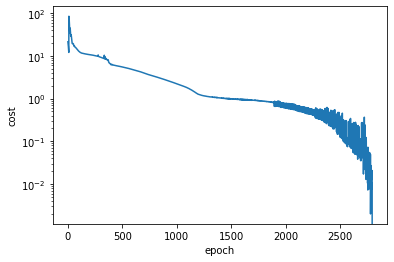

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()

As we can observe from the above plot, the optimization was a bit of a bumpy ride towards the end. Situations like this can often be improved by decreasing the learning rate when approaching the minimum. For that we could have used one of the `torch.optim.lr_scheduler` classes or manually stop the optimization at some point, decrease the learning rate and resume from where we stopped.

To conclude the example we will run a crosscheck with the MADX simulation tool, in order to verify the results. We can serialize the current version of the lattice using the functions `create_script, sequence_script, track_script` from the `build` module. With `madx.utils.run_script` we can run the thus generated script and get back the tracking results in form of `pd.DataFrame` objects.

In [14]:
madx_script = create_script(
    sequence=lattice,
    track=track_script(particles, observe=['target', 'dump'], maxaper=[100]*6),  # Aperture is already on the elements.
    beam=dict(charge=6, mass=11.1779291448, energy=28.5779291448)
)
with open('result.madx', 'w') as fh:
    fh.write(madx_script)

results = run_script(madx_script, ['trackone', 'trackloss'], twiss=True, madx=os.path.expanduser('~/bin/madx'))
print('\nCrosscheck with MADX:')
print('\tFraction of particles lost: ', len(results['trackloss'])/particles.shape[1])
print('\tBeam spot size at target:   ', results['trackone'].loc['target', ['X', 'Y']].values.std(axis=0))
print('\tBeam spot size at beam dump:', results['trackone'].loc['dump', ['X', 'Y']].values.std(axis=0))


Crosscheck with MADX:
	Fraction of particles lost:  0.006
	Beam spot size at target:    [0.00051271 0.00050737]
	Beam spot size at beam dump: [0.01056864 0.00879908]


There's a small deviation in the results due to the fact that we used linear optics for the tracking while MADX uses non-linear update formulas.

Finally let's plot the quadrupole gradients along the beamline:

Text(0, 0.5, 'K1L [1/m]')

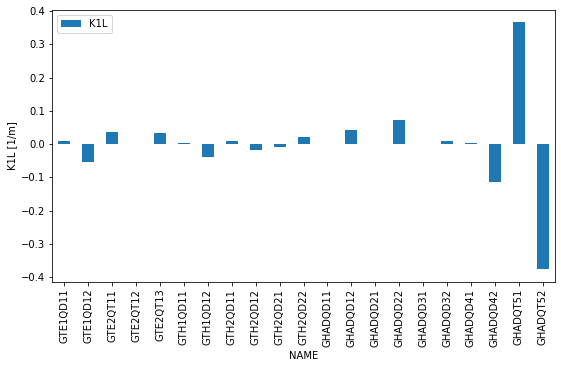

In [20]:
ax = results['twiss'][0].set_index('NAME').loc[[q.label.upper() for q in quadrupoles], ['K1L']].plot(kind='bar', figsize=(9, 5))
ax.set_ylabel('K1L [1/m]')